# Output statistics

After running your MIKE simulation, you would often want to make different kinds of summary statistics of your data - both for your own understanding and for communicating your results.

Examples of statistics

* Min, max, mean, standard deviation 
* Quantiles/percentiles (e.g. median, interquartile range, return period etc)
* Probability/frequency of exceedance

Types of aggregations

* Total - aggregate all data to a single number 
* Temporal - aggregate all time steps; for a dfsu 2d, the result would be a map
* Spatial - aggregate all elements to a single value per time step
* Others: monthly, by layer, spatial bin, sub domain etc... 

Ways of calculating

* [MIKEIO.Dataset](https://dhi.github.io/mikeio/dataset.html#methods) 
* [MIKEIO.generic](https://dhi.github.io/mikeio/generic.html) (temporal aggregations only; larger-than-memory)
* custom code (typically with NumPy)


:::{note}
This section uses features introduced in MIKE IO v 0.9.0 (released 2021-10-22)
:::

In [ ]:
from mikeio import Dfsu, generic

## Dataset

For smaller dfs files (maybe up to 2GB) it can be convenient to read the data to memory before doing aggregations. The MIKEIO.Dataset class have several [methods](https://dhi.github.io/mikeio/dataset.html#methods) for aggregating data along an axis. See the generic section below for larger-than-memory data. 

In [ ]:
dfs = Dfsu("data/NorthSea_HD_and_windspeed.dfsu")
ds = dfs.read()
ds

### Temporal aggregations: mean

The default is to aggregate along the time axis - the output will therefore be a map.

In [ ]:
dsm  = ds.mean()
mean_ws = dsm["Wind speed"]
mean_ws.shape

In [ ]:
dfs.plot(z=mean_ws)

The array is a 2d array, and the plot method expects a 1d array, so we select the the first and only timestep in the array.

In [ ]:
mean_ws_vec = mean_ws[0]
mean_ws_vec.shape

In [ ]:
dfs.plot(z=mean_ws_vec, label="Wind speed", title=f"Average {ds.time[0]} : {ds.time[-1]}");

### Spatial aggregations 

The Dataset aggregation methods (e.g. mean) takes an `axis` argument. If we give it the spatial axis (or the string 'space'), it will produce a time series of spatially aggregated values. 

In [ ]:
df = ds.mean(axis="space").to_dataframe()
df.head()

In [ ]:
df['Wind speed'].plot();

Dataset has other methods for calculating typical statistics, e.g. max, quantile...

In [ ]:

ds[["Wind speed"]].max(axis="space").to_dataframe().plot(title="Max wind speed");

In [ ]:
ds[["Wind speed"]].quantile(q=[0.1,0.5,0.9],axis="space").to_dataframe().plot();

### Quantiles to file

In [ ]:
dsq  = ds.quantile(q=[0.1,0.5,0.9])
dsq

Write to a new dfsu file

In [ ]:
dfs.write("NorthSea_Quantiles.dfsu", dsq)

![](images/mikezero_quantiles.png)

### Total

Aggregating over all data (both time and space) can be done from the Dataset in a few ways: 

* ds.describe() - will give you summary statistics like pandas df.describe()
* using axis=None in ds.mean(), ds.min()
* using standard NumPy aggregation functions on the Dataset data e.g. ds["Wind speed"].mean()

In [ ]:
ds.describe()

In [ ]:
ds.min(axis=None).to_dataframe()

In [ ]:
ds["Wind speed"].min()

## Generic

The [MIKEIO.generic](https://dhi.github.io/mikeio/generic.html) submodule can produce common **temporal** statistics on any dfs file (of any size). The output will be a new dfs file. Currently, generic has these methods for calculating statistics: 

* avg_time()
* quantile()

In [ ]:
generic.avg_time("data/NorthSea_HD_and_windspeed.dfsu", "NorthSea_avg.dfsu")

In [ ]:
dfs = Dfsu("NorthSea_avg.dfsu")
ds = dfs.read(items="Wind speed")
ds

In [ ]:
dfs.plot(ds["Wind speed"], title="Mean wind speed"); # this will fail for MIKE IO < 0.9.1 

In [ ]:
generic.quantile("data/NorthSea_HD_and_windspeed.dfsu", "NorthSea_Quantiles2.dfsu", q=[0.1, 0.5, 0.9])

![](images/mikezero_quantiles.png)

## Custom

Exceedance probability

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from mikeio import Dataset, eum

In [58]:
dfs = Dfsu("data/NorthSea_HD_and_windspeed.dfsu")
ds = dfs.read()
ds

<mikeio.Dataset>
Dimensions: (67, 958)
Time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Wind speed <Wind speed> (meter per sec)

In [116]:
nt = ds.n_timesteps
one_to_zero = 1. - np.arange(1., nt + 1.)/nt

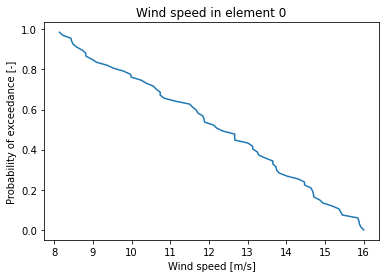

In [122]:
plt.plot(np.sort(ds["Wind speed"][:,0]), one_to_zero);
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Probability of exceedance [-]')
plt.title('Wind speed in element 0');

In [107]:
# Create empty Dataset 
items=[eum.ItemInfo(eum.EUMType.Probability)]
dse = Dataset(data=dfs.n_elements, time="2017-10-27", items=items)

In [118]:
threshold = 12
for j in range(ds.n_elements):
    # this is a naive and slow way of calculating this!
    dat = ds["Wind speed"][:,j]
    dse[0][0,j] = np.interp(threshold, np.sort(dat), one_to_zero)

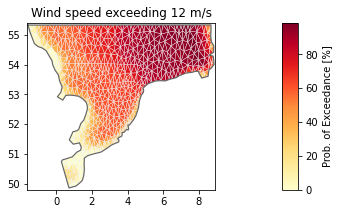

In [119]:
dfs.plot(dse*100, title="Wind speed exceeding 12 m/s", label="Prob. of Exceedance [%]", cmap="YlOrRd");